# Utilizing MCMC in Python to Explore the Parameter Space of an Exoplanet
###### By: Zachary Raup


### Objective: 
##### Using MCMC (Markov Chain Monte Carlo) to determine probability distributions of exoplanet parameters (Radius of Planet, Impact Parameter, Time of Mid-Transit) based on photometry data.

### Methodology:
##### - Develops a log likelihood function and applies MCMC algorithm to explore parameter space and quantify uncertainties.
##### - Constructs an exoplanet transit model using known parameters of TOI-4153.

### Data Source: 
##### Utilizes photometry data obtained from the 0.61 m telescope at the CR Chambliss Astronomical Observatory in Kutztown, PA.

### Visualization: 
##### Includes plotting of light curves, histograms, and cornerplots in matplotlib to visualize and analyze the exoplanet transit based on the photometry data.

### Presentation: 
##### Presented at the 241st AAS (American Astronomical Society) meeting.




##  Exoplanet
##  TOI 4153 | TIC 470171739 

### Known Parameters taken from ExoFOP:
##### https://exofop.ipac.caltech.edu/tess/target.php?id=470171739




#### Web TESS Viewing Tool
##### https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=470171739



#### The following is a portion of the Python code used the completion of this project

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batman
import emcee as mc
import corner as corn

Run a loglikelyhood funtion to get probability distribution

In [ ]:
# Log likelyhood funtion Probability
def logp(freeparams, BJD):
   
    # Parameters (Set free parameters(unknown) and fixed(known))           
    rplanetRearth = freeparams[0]        # free    # ExoFop 17.5913          
    rstarRsun = 1.672                              # ExoFop 1.672
    mstarMsun = 1.289                              # ExoFop 1.289
    ainAU = (P/365.25)**(2./3.)*mstarMsun**(1./3.) # Kep 3rd Law
    params = batman.TransitParams()                # exoplanet parameters from batman
    params.t0 = freeparams[1]           # free     # time of inferior conjunction       
    b = freeparams[2]                   # free     # impact parameter 
    params.per = P                                 # orbital period
    params.rp = rplanetRearth/rstarRsun/110.       # planet radius (in units of stellar radii)
    params.a = ainAU*215/rstarRsun                 # semi-major axis (in units of stellar radii)
    params.inc = 180*np.arccos(b/params.a)/np.pi   # orbital inclination (in degrees)
    params.ecc = 0.00                              # eccentricity
    params.w = 90.0                                # longitude of periastron (in degrees)
    params.u = [0.3, 0.3]                          #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       
    
# Set-Up Model using Batman transit modeler
    bat = batman.TransitModel(params, BJD)         # initialize model
    flux_mc = bat.light_curve(params)              # model of flux
    
    # Calculate difference between data collected and model
    dif_mc = data[:,1] - flux_mc
    
# Set restrictions for paramters   
    # Do not allow b to be less than 0 or greater than 1
    if b < 0: 
        return -1*np.inf
    if b > 1:
        return -1*np.inf
    
# Define log like funtion
    loglike = -0.5 * np.sum(dif_mc**2 / data[:,2]**2)

# Do not allow loglike to be (-)
    if loglike == loglike:
        return loglike
    else: 
        return -1*np.inf
    

In [ ]:
# Set dimensions of sampler 
ndim = 3                                              # number of free params

# Set number of walkers
nwalkers = 40 

# Set the initial (Buest Guess) parameter values for each walker:
r0 = [16.16, T0, 0.56]                                  # Set initial values for walkers

# Set starting point for each walker
Rp0_walker = r0[0] + 1e-3 * np.random.randn(nwalkers)   # walkers for Period # (days)
T0_walker = r0[1] + 1e-3 * np.random.randn(nwalkers)    # walkers for T0 #  (BJD)
b0_walker = r0[2] + 1e-3 * np.random.randn(nwalkers)

# Transpose 
r0 = np.transpose([Rp0_walker, T0_walker, b0_walker])  


In [ ]:
# Initialize the Sampler
sampler = mc.EnsembleSampler(nwalkers, ndim, logp, args=[BJD])

In [ ]:
# Run the Sampler:
state = sampler.run_mcmc(r0, 25000, progress = True)     # sampler.run_mcmc(initial values, number of itierations)
r = sampler.get_chain(flat=True, discard= 2000)          # Discard initial steps of walkers, allow for convergence

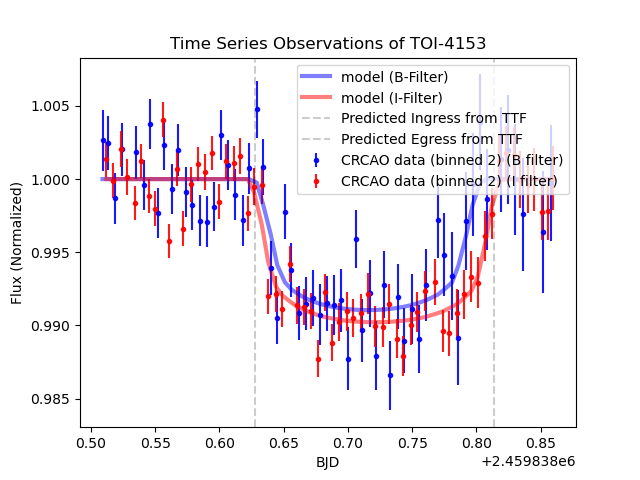